# HW4P1: Language Modelling

Welcome to the final part 1 hw of this course. This is the only part 1 in which you have PyTorch training (Yay). You will be working on training language models and evaluating them on the task of prediction and generation.<br>
The model which you will be coding in this HW very similar to the Speller module from HW4P2.

# Get modules and datasets

In [3]:
# !pip install torchsummaryX==1.1.0
# !pip install wandb --quiet
# !pip install matplotlib
# !pip install seaborn

# !pip install transformers -U
# !pip install tokenizers


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# # TODO: Import drive if you are using Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import sys
path = "/Users/aaayush/Documents/Deep_Learning/HW4P1/handout" # TODO: Add path to handout. For example ~/IDL/hw4/hw4p1_handout
sys.path.append(path)
%cd {path}

/Users/aaayush/Documents/Deep_Learning/HW4P1/handout


# Imports

In [5]:
%matplotlib inline

import torch

import os

import time
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torchsummaryX
import torch.nn as nn
import torch.nn.functional as F
import math
import gc
import glob
import wandb
import yaml
import json
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import get_linear_schedule_with_warmup
from torch.cuda.amp import GradScaler

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", DEVICE)


Device:  cpu


# Config

In [6]:
config = {
    "token_type":  "1k", # TODO: select a tokenzier from ["char", "1k", "10k"]
    "d_model":     512,
    "num_layers":  3,
    "num_heads":   8,
    "d_ff":        2048,
    "dropout":     0.1,
    "max_length":  1000,
    "lr":          1e-3,
    "batch_size":  32,
    "num_epochs":  50,
}

# Load datasets

In [7]:
# Define the vocabulary. Try printing and see
VOCAB = [
   "<sos>", "<eos>",
    "A",   "B",    "C",    "D",
    "E",   "F",    "G",    "H",
    "I",   "J",    "K",    "L",
    "M",   "N",    "O",    "P",
    "Q",   "R",    "S",    "T",
    "U",   "V",    "W",    "X",
    "Y",   "Z",    "'",    " ", "<pad>"
]

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}
# We have also included <sos> and <eos> in the vocabulary for you
# However in real life, you include it explicitly if not provided
PAD_TOKEN =  VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of Vocabulary    : {len(VOCAB)}")
print(f"VOCAB                   : {VOCAB}")
print(f"PAD_TOKEN               : {PAD_TOKEN}")
print(f"SOS_TOKEN               : {SOS_TOKEN}")
print(f"EOS_TOKEN               : {EOS_TOKEN}")

df_train = pd.read_csv("dataset/train-clean-100/transcripts.csv")
df_val = pd.read_csv("dataset/dev-clean/transcripts.csv")

df_train.head()

Length of Vocabulary    : 31
VOCAB                   : ['<sos>', '<eos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ', '<pad>']
PAD_TOKEN               : 30
SOS_TOKEN               : 0
EOS_TOKEN               : 1


,Unnamed: 0,transcripts
0,0,CHAPTER TEN SHAGGY MAN TO THE RESCUE THEY HAD ...
1,1,AT ONCE THEY HURRIED FORWARD TO SEE WHAT THIS ...
2,2,AND PICKED OUT THE EASIEST PLACES TO GO ALL IT...
3,3,LEAVING HOLES THAT MIGHT CAUSE THE UNWARY TO S...
4,4,WITH MY HEART RENDING GROWL MY HORRIBLE SHUDDE...


In [8]:
class CharTokenizer():
    ''' A wrapper around character tokenization to have a consistent interface with other tokeization strategies'''

    def __init__(self):
        self.eos_token = "<|endoftext|>"  # Same as EOS_TOKEN
        self.pad_token = "<|padding|>"
        self.unk_token = "<|unknown|>"

        characters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ '")

        # Create vocabulary mapping
        self.vocab = {
            self.eos_token: 0,
            self.pad_token: 1,  # Same ID as EOS_TOKEN
            self.unk_token: 2,
        }

        for idx, char in enumerate(characters, start=3):
            self.vocab[char] = idx

        self.inv_vocab = {v: k for k, v in self.vocab.items()}

        self.eos_token_id = self.vocab[self.eos_token]
        self.bos_token_id = self.vocab[self.eos_token]
        self.pad_token_id = self.vocab[self.pad_token]
        self.unk_token_id = self.vocab[self.unk_token]

        self.vocab_size = len(self.vocab)

    def tokenize(self, data):
        return [char for char in data]

    def encode(self, data, return_tensors=None):
        e = [self.vocab.get(char.upper(), self.unk_token) for char in data]
        if return_tensors == 'pt':
            return torch.tensor(e).unsqueeze(0)
        return e

    def decode(self, data):
        try:
            return ''.join([self.inv_vocab.get(j) for j in data])
        except:
            data = data.cpu().tolist()
            return ''.join([self.inv_vocab.get(j) for j in data])

    def convert_tokens_to_ids(self, token):
        return self.vocab[token]


In [9]:
# load tokenizer
if config["token_type"] == "1k":
    TOKENIZER = AutoTokenizer.from_pretrained("alexgichamba/hw4_tokenizer_1k")
    print("1k vocab tokenizer loaded")
elif config["token_type"] == "10k":
    TOKENIZER = AutoTokenizer.from_pretrained("alexgichamba/hw4_tokenizer_10k")
    print("10k vocab tokenizer loaded")
elif config["token_type"] == "char":
    TOKENIZER = CharTokenizer()
    print("character tokenizer loaded")
else:
    raise ValueError("Invalid token type")


UNK_TOKEN = TOKENIZER.unk_token_id
EOS_TOKEN = TOKENIZER.eos_token_id
SOS_TOKEN = TOKENIZER.bos_token_id
PAD_TOKEN = TOKENIZER.convert_tokens_to_ids('<|padding|>')

1k vocab tokenizer loaded


In [10]:
train_transcripts = [np.array([i for i in row['transcripts'].replace("<sos>", "").replace("<eos>", "") ]) for index, row in df_train.iterrows()]
train_dataset = []
for files in train_transcripts:
    tokenized = "".join(files)
    tokenized = TOKENIZER.encode(tokenized)
    train_dataset.append(tokenized)

val_transcripts = [np.array([i for i in row['transcripts'].replace("<sos>", "").replace("<eos>", "") ]) for index, row in df_val.iterrows()]
val_dataset = []
for files in val_transcripts:
    tokenized = "".join(files)
    tokenized = TOKENIZER.encode(tokenized)
    val_dataset.append(tokenized)

print(len(train_dataset))
print(len(val_dataset))

281241
2433


In [11]:
VOCAB_SIZE = TOKENIZER.vocab_size

# test the tokenizer
if TOKENIZER is not None:
    TOKENIZER.decode([EOS_TOKEN, SOS_TOKEN, PAD_TOKEN, UNK_TOKEN])
    print(TOKENIZER.tokenize("HELLO DEEP LEARNERS"))

['HE', 'LL', 'O', 'ĠDE', 'EP', 'ĠLE', 'AR', 'N', 'ERS']


In [12]:
print(train_dataset[0])
print(EOS_TOKEN, SOS_TOKEN, PAD_TOKEN, UNK_TOKEN)
TOKENIZER.decode(train_dataset[0])

[361, 469, 348, 258, 279, 362, 501, 40, 58, 421, 282, 262, 701, 36, 630, 412, 346, 352, 298, 460, 563, 781, 622, 270, 429, 40, 302, 422, 346, 333, 429, 322, 260, 259, 344, 670, 270, 462, 284, 658, 282, 611, 316, 262, 483, 344, 281, 663, 700, 500, 588, 52, 314, 708, 622, 445]
0 0 1 1000


'CHAPTER TEN SHAGGY MAN TO THE RESCUE THEY HAD NOT GONE VERY FAR BEFORE BUNGLE WHO HAD RUN ON AHEAD CAME BOUNDING BACK TO SAY THAT THE ROAD OF YELLOW BRICKS WAS JUST BEFORE THEM'

# Custom DataLoader

In [19]:
class DataLoaderForLanguageModeling(torch.utils.data.DataLoader): # Inherit from torch.utils.data.DataLoader
    """
        TODO: Define data loader logic here
    """
    # TODO: You can probably add more parameters as well. Eg. sequence length
    def __init__(self, dataset, batch_size, sequence_length=3, shuffle= True, drop_last= False):

        # If you remember, these are the standard things which you give while defining a dataloader.
        # Now you are just customizing your dataloader
        self.dataset    = dataset
        self.batch_size = batch_size
        self.shuffle    = shuffle
        self.drop_last  = drop_last
        self.sequence_length = sequence_length

        self.concatenated_dataset = np.concatenate(dataset)


    def __len__(self):
        # What output do you get when you print len(loader)? You get the number of batches
        # Your dataset has (579, ) articles and each article has a specified amount of words.
        # You concatenate the dataset and then batch parts of it according to the sequence length
        # TODO: return the number of batches
        # If you are using variable sequence_length, the length might not be fixed
        total_length = len(self.concatenated_dataset) // self.sequence_length
        num_batches = total_length // self.batch_size
        remainder = total_length % self.batch_size
        if not self.drop_last and remainder != 0:
            num_batches += 1
        return num_batches

    def __iter__(self):
        # TODO: Shuffle data if shuffle is True
        if self.shuffle:
            np.random.shuffle(self.concatenated_dataset)

        # TODO: Concatenate articles drop extra words that won't fit into a full batch
        total_length = (len(self.concatenated_dataset) // self.sequence_length) * self.sequence_length
        self.concatenated_dataset = self.concatenated_dataset[:total_length]

        inputs, targets = [], []

        for i in range(0, len(self.concatenated_dataset) - self.sequence_length, self.sequence_length):
            input_seq = self.concatenated_dataset[i:i + self.sequence_length]
            target_seq = self.concatenated_dataset[i + 1:i + self.sequence_length + 1]
            inputs.append(input_seq)
            targets.append(target_seq)


        inputs = np.array(inputs)
        targets = np.array(targets)
        
        if not self.drop_last and len(inputs) % self.batch_size != 0:
            padding_size = self.batch_size - (len(inputs) % self.batch_size)
            pad_input = np.full((padding_size, self.sequence_length), PAD_TOKEN)
            pad_target = np.full((padding_size, self.sequence_length), PAD_TOKEN)
            inputs = np.concatenate((inputs, pad_input))
            targets = np.concatenate((targets, pad_target))

        else:
            total_batches = len(inputs) // self.batch_size
            inputs = inputs[:total_batches * self.batch_size]
            targets = targets[:total_batches * self.batch_size]
    
        num_batches = len(inputs) // self.batch_size
        inputs = inputs.reshape(num_batches, self.batch_size, self.sequence_length)
        targets = targets.reshape(num_batches, self.batch_size, self.sequence_length)
    
        # Yield each batch
        for i in range(num_batches):
            input_batch = inputs[i]
            target_batch = targets[i]
            yield torch.tensor(input_batch, dtype=torch.long), torch.tensor(target_batch, dtype=torch.long)

In [24]:
dl = DataLoaderForLanguageModeling(
    dataset = train_dataset,
    batch_size = config['batch_size'],
    shuffle = True,
    drop_last = False,
    sequence_length = 4
)

In [25]:
# Some sanity checks

inputs, targets = next(iter(dl))
print(inputs.shape, targets.shape)
for x, y in dl:
    transcript = TOKENIZER.decode(x[0].tolist())
    transcript_y = TOKENIZER.decode(y[0].tolist())
    print("x: ", transcript)
    print("y: ", transcript_y)
    break

torch.Size([32, 4]) torch.Size([32, 4])
x:   FACE HISALL THEIR
y:   HISALL THEIRC


# Causal Language Model

Causal language models predict the probability of a word based on the preceding words in the sentence. This differs from bidirectional models, which consider both previous and following context. Here, we use a Transformer-based decoder, leveraging its attention mechanism to focus only on earlier parts of the sequence to predict the next word. This type of modeling is suitable for tasks such as text generation where the sequence order is crucial.


**Link to HuggingFace Documentation**: [Causal Language Model](https://huggingface.co/docs/transformers/en/tasks/language_modeling)

The following image can be a helpful aid in visualizing the flow of information in a causal language model, highlighting how each word in a sequence is used to predict the next word.

<img src="https://github.com/christianversloot/machine-learning-articles/blob/main/images/causal-1024x445.png?raw=true" width="60%">

This figure shows three matrices: the attention scores between sequence elements, the causal mask with zeros allowing attention and negative infinity blocking future attention, and the resultant matrix after applying the causal mask. The negative infinity values in the causal mask prevent the model from using future tokens in its predictions, reinforcing the sequence's order. This visualization shows how transformers can be used for causal language modeling where future input information must not influence current predictions.

<img src="https://github.com/christianversloot/machine-learning-articles/raw/main/images/Diagram-20-1024x282.png" width="80%">


## 2. `create_mask`: Mask for Preventing Attention to Subsequent Positions


```python
def create_mask(seq, pad_idx=None)
```


## Purpose:
This function creates a **subsequent mask** that prevents attention from attending to future positions in the sequence. It ensures that each position can only attend to previous positions (as in causal language modeling).

## Usage:
- **Input:**
  - `seq`: Tensor of shape `(batch_size, sequence_length)` representing the input sequence.
  - `pad_idx`: (Optional) Padding index for masking padding positions.

- **Output:**
  - A mask of shape `(batch_size, sequence_length, sequence_length)` where the upper triangular portion is filled with 1s to prevent attention to future positions.

### The Expected mask should look like the image below:

<img src="https://i.imgur.com/AJdqMGx.png" alt="drawing" width="400"/>


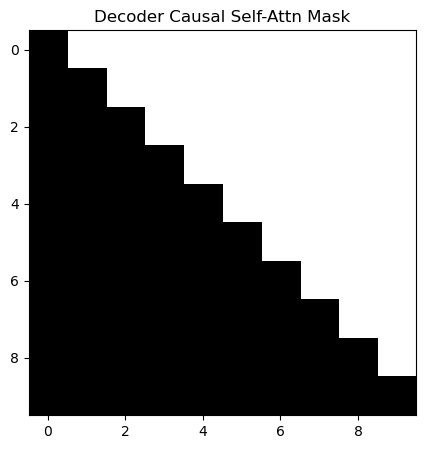

In [26]:
def create_mask(seq, pad_idx=None):
    """ Create a mask to prevent positions from attending to subsequent positions.

    Args:
        seq: The input sequence tensor, shape (batch_size, sequence_length).

    Returns:
        A mask tensor with shape (batch_size, sequence_length, sequence_length),
            where positions are allowed to attend to previous positions but not to subsequent positions.
    """

    sz_b, len_s = seq.size()

    # Create an upper triangular matrix with zeros on the diagonal and below (indicating allowed positions)
    #   and ones above the diagonal (indicating disallowed positions)

    subsequent_mask = torch.triu(torch.ones(len_s, len_s), diagonal=1).bool()

    # Expand the mask to match the batch size, resulting in a mask for each sequence in the batch.
    mask = subsequent_mask.unsqueeze(0).expand(sz_b, -1, -1)  # b x ls x ls


    ''' Create a mask to ignore padding positions in the key sequence during attention calculation. '''

    # Expanding to fit the shape of key query attention matrix.
    if pad_idx != None:
        len_q = seq.size(1)

          # Create a mask where padding positions in the key sequence are marked with 1.
        padding_mask  = seq.eq(pad_idx)

          # Expand the mask to match the dimensions of the key-query attention matrix.
        padding_mask  = padding_mask.unsqueeze(1).expand(-1, len_q, -1)  # b x lq x lk


        mask          = (padding_mask + mask).gt(0)

    else:
        mask = mask.gt(0)

    return mask






dec_causal_mask         = create_mask( torch.randn(4, 10)  , pad_idx=0)

# Black portions are attended to
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

axs.imshow(dec_causal_mask[0], cmap="gray", aspect='auto')
axs.set_title("Decoder Causal Self-Attn Mask")


plt.show()



# Transformer Decoder Components

We will use these components in the Transformer decoder. These include positional encoding, feed-forward networks, scaled dot-product attention, and multi-head attention. Each of these components plays a vital role in processing input sequences and computing attention in the Transformer model.

---

## 1. **Positional Encoding (`PositionalEncoding`)**
Transformers do not inherently capture the order of sequences, so positional encodings are used to introduce sequence order into the model.

- **Purpose**: Adds information about the position of each token in the input sequence.
- **Mechanism**: Uses a combination of sine and cosine functions of different frequencies to generate positional encodings.
- **Parameters**:
  - `projection_size`: The size of the input embeddings (i.e., `d_model`).
  - `max_seq_len`: The maximum length of the input sequence (default: 1000).
- **Output**: The input embedding enriched with positional information, which is passed through a dropout layer for regularization.

---


In [27]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, projection_size, max_seq_len= 1000, dropout=0.1):
        super().__init__()
        self.dropout                = torch.nn.Dropout(dropout)

        pe              = torch.zeros(max_seq_len, projection_size)
        position        = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term        = torch.exp(torch.arange(0, projection_size, 2).float() * (-math.log(10000.0) / projection_size))
        pe[:, 0::2]     = torch.sin(position * div_term)
        pe[:, 1::2]     = torch.cos(position * div_term)
        pe              = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.dropout(x + self.pe[:, :x.size(1)])





## 2. **Feed-Forward Network (`FeedForward`)**
The feed-forward network is a fully connected layer applied independently to each position in the sequence after the attention layers.

- **Purpose**: Projects the intermediate representations to a higher-dimensional space and back to the original model dimension.
- **Mechanism**: Consists of two linear layers with a GeLU activation function and dropout in between.
- **Parameters**:
  - `d_model`: The input and output dimensionality of the model.
  - `d_ff`: The dimensionality of the hidden layer in the feed-forward network (default: 2048).
  - `dropout`: Dropout rate applied after the GeLU activation (default: 0.1).
- **Output**: The transformed input sequence passed through two linear transformations with non-linear activation in between.

---

In [28]:

class FeedForward(torch.nn.Module):
    ''' Projection Layer (Fully Connected Layers) '''

    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()

        self.linear_1   = torch.nn.Linear(d_model, d_ff)
        self.dropout    = torch.nn.Dropout(dropout)
        self.linear_2   = torch.nn.Linear(d_ff, d_model)

    def forward(self, x):

        # Apply the first linear layer, GeLU activation, and then dropout
        x = self.dropout(torch.nn.functional.gelu(self.linear_1(x)))

        # Apply the second linear layer to project the dimension back to d_model
        x = self.linear_2(x)

        return x




## 3. **Scaled Dot-Product Attention (`ScaledDotProductAttention`)**
This module computes the attention score for each query-key pair in the input sequence using the scaled dot-product mechanism.

- **Purpose**: To compute attention scores and generate weighted outputs based on the input query, key, and value matrices.
- **Mechanism**:
  - Calculates the dot product of queries and keys, scales by the square root of the dimension, and applies a softmax to generate attention weights.
  - Uses dropout for regularization.
- **Parameters**:
  - `temperature`: Scaling factor for the dot product.
  - `attn_dropout`: Dropout rate for attention weights (default: 0.1).
- **Output**: Returns the weighted sum of the values and the attention weights.

---



In [29]:
class ScaledDotProductAttention(torch.nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature    = temperature                       # Scaling factor for the dot product
        self.dropout        = torch.nn.Dropout(attn_dropout)    # Dropout layer for attention weights
        self.softmax        = torch.nn.Softmax(dim=-1)           # Softmax layer along the attention dimension

    def forward(self, q, k, v, mask=None):

        # Calculate the dot product between queries and keys.
        # attn = torch.bmm(q, k.transpose(1, 2))
        attn = (q @ k.transpose(-2, -1))

        # Scale the dot product by the temperature.
        attn = attn / self.temperature

        if mask is not None:
            # Apply the mask by setting masked positions to a large negative value.
            # This ensures they have a softmax score close to zero.
            attn = attn.masked_fill(mask, float('-inf'))

        # Apply softmax to obtain attention weights.
        attn    = self.softmax(attn)

        # Apply dropout to the attention weights.
        # Compute the weighted sum of values based on the attention weights.
        # output  = torch.bmm(self.dropout(attn), v)
        attn = self.dropout(attn)
        output = attn @ v

        return output, attn # Return the attention output and the attention weights.


## 4. **Multi-Head Attention (`MultiHeadAttention`)**
This module implements multi-head attention, where multiple sets of attention heads are computed in parallel, and their outputs are concatenated.

- **Purpose**: To allow the model to jointly attend to different positions in the input sequence from different representation subspaces.
- **Mechanism**:
  - Projects the input query, key, and value matrices into multiple smaller subspaces (heads).
  - Computes scaled dot-product attention for each head in parallel.
  - Concatenates the outputs of all heads and applies a final linear transformation to project the result back to the original model dimension.
- **Parameters**:
  - `n_head`: Number of attention heads.
  - `d_model`: Dimensionality of the input and output representations.
  - `dropout`: Dropout rate applied to the attention output (default: 0.1).
- **Output**: Returns the concatenated output of all attention heads and the averaged attention weights.

---

In [30]:
class MultiHeadAttention(torch.nn.Module):
    ''' Multi-Head Attention Module '''

    def __init__(self, n_head, d_model, dropout=0.1):
        super().__init__()

        self.n_head = n_head # Number of attention heads
        self.d_k    = d_model // n_head
        self.d_v    = d_model // n_head


        # Linear layers for projecting the input query, key, and value to multiple heads
        self.w_qs   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_ks   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_vs   = torch.nn.Linear(d_model, n_head * self.d_v)

        torch.nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_v)))

        # Initialize the weights of the linear layers
        self.attention = ScaledDotProductAttention(
            temperature=np.power(self.d_k, 0.5), attn_dropout=dropout)

        # Final linear layer to project the concatenated outputs of the attention heads back to the model dimension
        self.fc = torch.nn.Linear(n_head * self.d_v, d_model)
        torch.nn.init.normal_(self.fc.weight)

        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):

        # following key, value, query standard computation
        d_k, d_v, n_head    = self.d_k, self.d_v, self.n_head
        sz_b, len_q, _      = q.size()
        sz_b, len_k, _      = k.size()
        sz_b, len_v, _      = v.size()

        # Project the input query, key, and value to multiple heads
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Rearrange the dimensions to group the heads together for parallel processing
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)


        # Repeat the mask for each attention head if a mask is provided
        if mask is not None:
              # print(mask.shape)
              mask = mask.unsqueeze(1).repeat(1, n_head, 1, 1)

        # Apply scaled dot-product attention to the projected query, key, and value
        output, attn    = self.attention(q, k, v, mask=mask)

        # Rearrange the output back to the original order and concatenate the heads
        output = output.transpose(1, 2).contiguous().view(sz_b, len_v, -1)

        output          = self.dropout(self.fc(output))

        attn_weights = attn.mean(dim=(0, 1))

        return output, attn_weights


# Transformer Decoder Layers

The `DecoderLayer1` and `DecoderLayer3` are modular components of the Transformer decoder. Each layer is designed to handle a specific function: self-attention, cross-attention, and feed-forward processing.

## 1. `DecoderLayer1`: Self-Attention Layer
- **Purpose**: Implements self-attention, where the decoder attends to its own inputs, combined with residual connections and layer normalization.
- **Components**:
  - `MultiHeadAttention`: Applies self-attention to the target sequence.
  - `LayerNorm`: Normalizes the output after the residual connection.
  - `Dropout`: Regularization to prevent overfitting.

## 3. `DecoderLayer3`: Feed-Forward Layer
- **Purpose**: Implements a feed-forward neural network for further transformation of the decoder's intermediate representations.
- **Components**:
  - `FeedForward`: A two-layer fully connected network with non-linearity.
  - `LayerNorm`: Applied after the residual connection.
  - `Dropout`: Regularization to avoid overfitting.



In [31]:
class DecoderLayer1(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        """
        DecoderLayer (attention and layer norm) in the Transformer architecture.

        Args:
            d_model (int): The number of expected features in the input (embedding dimension).
            num_heads (int): Number of attention heads.
            d_ff (int): Dimension of the feedforward network model.
            dropout (float): Dropout probability.
        """
        super(DecoderLayer1, self).__init__()

        # TODO: fill in the blanks appropriately (given the modules above)
        self.self_attn =  MultiHeadAttention(num_heads, d_model, dropout)
        self.layer_norm = torch.nn.LayerNorm(d_model)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, tgt, attn_mask=None, key_padding_mask=None):
        # TODO: apply layer norm to input
        tgt_norm = self.layer_norm(tgt)

        # TODO: call self attention with mask
        attn_output, attn_weights = self.self_attn(tgt_norm, tgt_norm, tgt_norm, mask=attn_mask)

        # TODO: apply dropout
        attn_output = self.dropout(attn_output)

        # TODO: add skip connection
        tgt = tgt + attn_output

        return tgt, attn_weights


class DecoderLayer3(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        """
        Feedforward layer with layer normalization in the Transformer decoder.

        Args:
            d_model (int): Embedding dimension.
            num_heads (int): Number of attention heads.
            d_ff (int): Dimension of the feedforward network.
            dropout (float): Dropout probability.
        """
        super(DecoderLayer3, self).__init__()

        # TODO: fill in the blanks appropriately (given the modules above)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.layer_norm = torch.nn.LayerNorm(d_model)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, tgt):
        # TODO: apply layer norm to input
        tgt_norm = self.layer_norm(tgt)

        # TODO: call feed forward layer
        ffn_output = self.ffn(tgt_norm)

        # TODO: apply dropout
        ffn_output = self.dropout(ffn_output)

        # TODO: add skip connection
        tgt = tgt + ffn_output

        return tgt


# Causal Language Model

This module implements a Transformer-based decoder for causal language modeling (CLM). It consists of several components, including embedding layers, positional encoding, self-attention layers, and feed-forward layers. It supports various generation strategies such as beam search and sampling.

### Key Components:
- **Embedding Layer**: Converts input tokens into dense vector representations.
- **Positional Encoding**: Adds position information to input tokens, helping the model understand the order of tokens.
- **Decoder Layers**: Composed of:
  - `DecoderLayer1`: Implements self-attention and layer normalization.
  - `DecoderLayer3`: Implements a feed-forward network with residual connections.
- **Output Linear Layer**: Projects the hidden states to the vocabulary size to generate output probabilities.

### Key Methods:
- **`forward`**: Runs the input through the decoder layers and generates output probabilities.

In [32]:
class CausalLanguageModel(nn.Module):
    def __init__(self, vocab_size=31, d_model=256, num_layers=2, num_heads=2, d_ff=512, dropout=0.1, max_length=1000):

        """
        Decoder module in the Transformer architecture.
        Initializes embeddings, multiple decoder layers, and an output linear layer.

        Args:
            vocab_size (int): Size of the vocabulary.
            d_model (int): The number of expected features in the input (embedding dimension).
            num_layers (int): Number of decoder layers.
            num_heads (int): Number of attention heads.
            d_ff (int): Dimension of the feedforward network model.
            dropout (float): Dropout probability.
            max_length (int): Maximum length of input sequences.
        """
        super(CausalLanguageModel, self).__init__()

        # TODO: fill in the blanks appropriately (given the modules above)

        self.embedding = torch.nn.Embedding(vocab_size, d_model)

        self.pos_encoder = PositionalEncoding(d_model, max_seq_len=max_length, dropout=dropout)
        self.num_layers= num_layers
        self.dec_layers1 = nn.ModuleList([DecoderLayer1(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dec_layers3 = nn.ModuleList([DecoderLayer3(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.layer_norm = torch.nn.LayerNorm(d_model)
        self.fully_connected = torch.nn.Linear(d_model, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def forward(self, inp):
        # TODO: generate the causal mask using the given function
        attn_mask = create_mask(inp)

        # TODO: convert input to embeddings
        inp = self.embedding(inp)

        # TODO: apply positional encoding
        inp = self.pos_encoder(inp)

        attention_weights_list = []

        for i in range(self.num_layers):
            # TODO: apply decoder layer
            inp, attn_weights = self.dec_layers1[i](inp, attn_mask=attn_mask)
            inp = self.dec_layers3[i](inp)
            attention_weights_list.append(attn_weights)

        # TODO: apply layernorm and the fully connected layer for classification
        output = self.fully_connected(self.layer_norm(inp))

        stacked_attention_weights = torch.stack(attention_weights_list, dim=0)

        return output, stacked_attention_weights


# Model, Loss, Optimizer, and Scheduler Definition

In [33]:
# TODO: Define the model
model = CausalLanguageModel(
    vocab_size = VOCAB_SIZE,
    d_model    = config['d_model'],
    num_layers = config['num_layers'],
    num_heads  = config['num_heads'],
    d_ff       = config['d_ff'],
    dropout    = config['dropout'],
    max_length = config['max_length']
).to(DEVICE)

# TODO: Define the dataloader
train_loader = DataLoaderForLanguageModeling(
    dataset=train_dataset,
    batch_size=config['batch_size'],
    sequence_length=100,
    shuffle=True,
    drop_last=True
)

val_loader = DataLoaderForLanguageModeling(
    dataset=val_dataset,
    batch_size=config['batch_size'],
    sequence_length=100,
    shuffle=False,
    drop_last=True
)

# TODO: Define the criterion
criterion = torch.nn.CrossEntropyLoss()

# TODO: Define the optimizer
optimizer =  torch.optim.Adam(model.parameters(), lr=config['lr'])

# TODO: Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['num_epochs'])

# Optional TODO: Define the scaler for mixed precision training
scaler = GradScaler()

# Print the model architecture and parameter summary
print(model)

# Optionally, if you want to summarize the model, make sure `torchsummaryX` is installed
summary = torchsummaryX.summary(model.to(DEVICE), x=torch.tensor(inputs).to(DEVICE))



CausalLanguageModel(
  (embedding): Embedding(1000, 512)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_layers1): ModuleList(
    (0-2): 3 x DecoderLayer1(
      (self_attn): MultiHeadAttention(
        (w_qs): Linear(in_features=512, out_features=512, bias=True)
        (w_ks): Linear(in_features=512, out_features=512, bias=True)
        (w_vs): Linear(in_features=512, out_features=512, bias=True)
        (attention): ScaledDotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (softmax): Softmax(dim=-1)
        )
        (fc): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (dec_layers3): ModuleList(
    (0-2): 3 x DecoderLayer3(
      (ffn): FeedForward(
        (linear_1): Linear(in_features=512, out_features=2048, bia

/Users/aaayush/anaconda3/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/m5/snsrmpyn36q83rw1hrlnts640000gn/T/ipykernel_84145/105305481.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  summary = torchsummaryX.summary(model.to(DEVICE), x=torch.tensor(inputs).to(DEVICE))




# Trainer Class

In [34]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, optimizer, criterion, scheduler, scaler, max_epochs= 1):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model      = model
        self.train_loader = train_loader
        self.val_loader   = val_loader
        self.optimizer  = optimizer
        self.criterion  = criterion
        self.scheduler  = scheduler
        self.scaler     = scaler

        self.train_losses           = []
        self.val_losses             = []
        self.prediction_probs       = []
        self.prediction_probs_test  = []
        self.generated_texts_test   = []
        self.generated_texts_test_beam = []
        self.generated_texts_test_beam_random = []
        self.generated_texts_validation = []

        self.log_likelihood_beam = []
        self.log_likelihood_beam_random = []

        self.epochs                 = 0
        self.max_epochs             = max_epochs


    def calculate_loss(self, out, target):
        # output: (B, T, Vocab_size) - probability distributions
        # target: (B, T)
        # Read the documentation of CrossEntropyLoss and try to understand how it takes inputs

        # Tip: If your target is of shape (B, T) it means that you have B batches with T words.
        # Tip: What is the total number of words in this batch?
        # Tip: Crossentropy calculates the loss between a label and its probability distribution.

        out = out.view(-1, out.size(-1))
        targets = target.view(-1)
        loss    = self.criterion(out, targets)

        return loss


    def train(self):

        self.model.train() # set to training mode
        epoch_loss  = 0
        num_batches = 0
        attn_weights = None

        for batch_num, (inputs, targets) in enumerate(tqdm(self.train_loader)):

            # TODO: Complete the loop. You should be able to complete this without any helper comments after 3 HWs
            # Tip: Use Mixed Precision Training
            # For loss calculation, use the calculate_loss function. You need to complete it before using.
            
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            with torch.cuda.amp.autocast():
                outputs, attn_weights = self.model(inputs)
    
                loss = self.calculate_loss(outputs, targets)

            self.optimizer.zero_grad()
            self.scaler.scale(loss).backward() 
            self.scaler.step(self.optimizer)
            self.scaler.update()
    
            # Update epoch loss
            epoch_loss += loss.item()
            num_batches += 1


        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN] \tEpoch [%d/%d] \tLoss: %.4f \tLr: %.6f'
                     % (self.epochs, self.max_epochs, epoch_loss, self.optimizer.param_groups[0]['lr']))
        self.train_losses.append(epoch_loss)

        return (epoch_loss, self.optimizer.param_groups[0]['lr'], attn_weights)

    def validate(self):

        self.model.eval() # set to eval mode
        epoch_loss  = 0
        num_batches = 0
        attn_weights = None

        with torch.no_grad():  # No gradients needed for validation
            for batch_num, (inputs, targets) in enumerate(tqdm(self.val_loader)):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    
                outputs, attn_weights = self.model(inputs)
    
                loss = self.calculate_loss(outputs, targets)

                epoch_loss += loss.item()
                num_batches += 1


        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[VAL] \tEpoch [%d/%d] \tLoss: %.4f \tLr: %.6f'
                     % (self.epochs, self.max_epochs, epoch_loss, self.optimizer.param_groups[0]['lr']))
        self.train_losses.append(epoch_loss)

        return epoch_loss


In [35]:
# The object of the Trainer class takes in everything
trainer = Trainer(
    model       = model,
    train_loader = train_loader,
    val_loader  = val_loader,
    optimizer   = optimizer,
    criterion   = criterion,
    scheduler   = scheduler,
    scaler      = scaler,
    max_epochs  = config["num_epochs"], # TODO: set the number of epochs
)

# Wandb

In [36]:
# Use wandb? Resume Training?
USE_WANDB = True
RESUME_LOGGING = False

# Create your wandb run

run_name = "Run - 1" # TODO: pick a run name you like

if USE_WANDB:

    wandb.login(key="7664f3b17a98ffe7c64b549e349123b61a9d3024") # your wandb key

    if RESUME_LOGGING:
        run_id = ''
        run = wandb.init(
            settings=wandb.Settings(symlink=False),
            id     = run_id, ### Insert specific run id here if you want to resume a previous run
            resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
            project = "hw4p1-f24", ### Project should be created in your wandb account
        )
    else:
        run = wandb.init(
            name    = run_name, ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True, ### Allows reinitalizing runs when you re-run this cell
            project = "hw4p1-f24", ### Project should be created in your wandb account
            config  = config ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)
        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### log it in your wandb run with wandb.save()
        wandb.save('model_arch.txt')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Currently logged in as: aaayush (aaayush-carnegie-mellon-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consi

# Experiments

In [37]:
# Run the experiments loop.
# Each epoch wont take more than 2-3min. If its taking more time, it might be due to (but not limited to) the following:
#   * You might be overlapping batches
#       Eg. Input: "I had biryani for lunch today" and sequence length = 3,
#           --> "I had biryani", "for lunch today" are ideal examples for inputs
#           --> "I had biryani", "had biryani for", "biryani for lunch", ... is just redundant info :')
#   * Your length calculation in the dataloader might be wrong
# If you haven't had biryani, try it :D

wandb.watch(model, log="all")

# torch.cuda.empty_cache()
gc.collect()


for epoch in range(config['num_epochs']):
    train_loss, curr_lr,  attn_weights = trainer.train()
    print(attn_weights[-1].shape)

    test_loss = trainer.validate()

    wandb.log({"train_loss":train_loss,
               "test_loss": test_loss,
               "learning_rate": curr_lr
              })
    scheduler.step()

### Finish your wandb run
run.finish()

torch.cuda.empty_cache()
gc.collect()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/5254 [00:00<?, ?it/s]

/Users/aaayush/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


KeyboardInterrupt: 

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


# Testing Your Model's Perplexity

In [ ]:
def log_softmax(x, axis):
    ret = x - np.max(x, axis=axis, keepdims=True)
    lsm = np.log(np.sum(np.exp(ret), axis=axis, keepdims=True))
    return ret - lsm

def get_prediction_nll_single_for_test(out, targ):
    out = log_softmax(out, 1)
    nlls = out[np.arange(out.shape[0]), targ]
    nll = -np.sum(nlls)
    return nll

In [ ]:
test_df = pd.read_csv("dataset/test-clean/transcripts.csv")
test_transcripts  = []
test_transcripts = [np.array([i for i in row['transcripts'].replace("<sos>", "").replace("<eos>", "") ]) for index, row in test_df.iterrows()]

test_dataset = []
for files in test_transcripts:
    tokenized = "".join(files)
    tokenized = TOKENIZER.encode(tokenized)
    test_dataset.append(tokenized)

In [ ]:
test_dl = DataLoaderForLanguageModeling(
    dataset         = test_dataset,
    batch_size      = 1,
    shuffle         = False,
    drop_last       = False,
    sequence_length = 100
)

nnls = []
model.eval()

for batch_num, (inputs, targets) in enumerate(tqdm(test_dl)):
    inputs = torch.tensor(inputs).long().to(DEVICE)
    targets = torch.tensor(targets).long().to(DEVICE)

    with torch.no_grad():
        output = model(inputs)
    nnl = get_prediction_nll_single_for_test(output[0][0].to('cpu').numpy(), targets[0].to('cpu').numpy())
    if TOKENIZER != None:
        text_len = len(TOKENIZER.decode(targets.flatten().to('cpu')).replace("<|endoftext|>", "")) + 1
    else:
        text_len = len(targets[0])
    nnls.append(nnl / text_len)

test_ppl = np.exp(sum(nnls) / len(nnls))
print(f'test_perplexity: {test_ppl}')
with open('./hw4/test_perplexity.txt', 'w') as f:
    f.write(str(test_ppl))